# Claim2Title

This notebook will investigate whether I can use a sequence to sequence model to generate patent specification title from patent claim text.

## Getting the Data

First we need a source of say ~ 10,000 titles and claims. We'll concentrate on G06 as crossing the streams of chemistry and computing results in some funky chimeras.

In [1]:
# imports
from patentdata.corpus import USPublications
from patentdata.models.patentcorpus import LazyPatentCorpus
import os, pickle

We need to fold in the functions below into patentdata.

In [2]:
# Get the claim 1 and classificationt text

PIK = "claim_and_title.data"

if os.path.isfile(PIK):
    with open(PIK, "rb") as f:
        print("Loading data")
        data = pickle.load(f)
        print("{0} claims and titles loaded".format(len(data)))
else:
    # Load our list of G06 records
    records_file = "12000recordsG06.data"

    if os.path.isfile(records_file):
        with open(records_file, "rb") as f:
            print("Loading data")
            records = pickle.load(f)
            print("{0} records loaded".format(len(records)))
        ds = USPublications(path)
    else:
        path = '/media/SAMSUNG1/Patent_Downloads'
        ds = USPublications(path)
        records = ds.get_records(["G", "06"], "name", sample_size=12000)
        with open(records_file, "wb") as f:
            pickle.dump(records, f)
            print("{0} records saved".format(len(records)))
    
    lzy = LazyPatentCorpus()
    lzy.init_by_filenames(ds, records)
    
    data = list()
    for i, pd in enumerate(lzy.documents):
        try:
            title = pd.title
        except:
            title = ""
        try:
            claim1_text = pd.claimset.get_claim(1).text
        except:
            claim1_text = ""
        current_data = (claim1_text, title)
        data.append(current_data)
        if (i % 500) == 0:
            print("Saving a checkpoint at {0} files".format(i))
            print("Current data = ", current_data)
            with open(PIK, "wb") as f:
                pickle.dump(data, f)
            
    with open(PIK, "wb") as f:
        pickle.dump(data, f)
        
    print("{0} claims saved".format(len(data)))

Loading data
12000 claims and titles loaded


In [3]:
data[1]

('\n1. An image forming apparatus, comprising: \nsetting section to be used by a user for setting, as a copying mode, a writing space mode in which a document image in a preset number are printed on a half of a single paper sheet, thus forming a writing space on the other half of the paper sheet, and \nimage forming section for printing the document image in the preset number on a half of a single paper sheet when the writing space mode has been set as a copying mode. \n\n',
 'Image forming apparatus having writing space mode')

In [4]:
# Check for and remove 'cancelled' claims
data = [d for d in data if '(canceled)' not in d[0]]

print("There are now {0} claims after filtering out cancelled claims".format(len(data)))

There are now 11428 claims after filtering out cancelled claims


In [5]:
# Clean the characters in the data to use a reduced set of printable characters
# There is a function in patentdata to do this
from patentdata.models.lib.utils import clean_characters

data = [(clean_characters(d[0]), clean_characters(d[1])) for d in data]

### Breaking Up Claims

Studies of human reading comprehension show that sentences of length 8-15 words long are easily understood. Over that comprehension quickly decreases. (See here: http://prsay.prsa.org/2009/01/14/how-to-make-your-copy-more-readable-make-sentences-shorter/)

This suggests we want to be breaking our claims into ~8-15 word chunks then combining an output of these chunks. Break on punctuation - e.g. comma clauses (but not lists) and semi-colons.  

We can start with our hacky split_into_features method in patentdata library.

Can we parse chunks through an RNN encoder and then combine those chunks? Concatenation would not work as you may have a variable number of chunks. Averaging or summing encoded vectors may work.  

"A reasonable limit of 250-500 time steps is often used in practice with large LSTM models." - as per https://machinelearningmastery.com/handle-long-sequences-long-short-term-memory-recurrent-neural-networks/.

Can we cascade RNN cells as per here: http://www.xiaodanzhu.com/publications/zhu_icml_15.pdf?

In [6]:
length = max([len(d[0]) for d in data])
print("Our longest claim is {0} characters long.".format(length))

Our longest claim is 23654 characters long.


In [7]:
length = max([len(d[1]) for d in data])
print("Our longest title is {0} characters long.".format(length))

Our longest title is 397 characters long.


This is too long for simple LSTM seq2seq systems that rely on 250-500 timesteps.  

We could though use characters out and words in?!

Thinking about text tokenisation - TF-IDF or count seems wrong - we have more of a summarisation task.

In [8]:
from keras.preprocessing import text
t_claim = text.Tokenizer(
                num_words=10000, 
                filters='1.:;\n',
                lower=True,
                split=" ",
                char_level=False
)
X_texts = [d[0] for d in data]
t_claim.fit_on_texts(X_texts)
X_seqs = t_claim.texts_to_sequences(X_texts)

Using TensorFlow backend.


Let's start just with a words to words seq-to-seq. We can branch out to a words to chars seq-to-seq later if necessary.

In [9]:
t_title = text.Tokenizer( 
                num_words=5000,
                lower=True,
                char_level=False
)
Y_texts = [d[1] for d in data]
t_title.fit_on_texts(Y_texts)
Y_seqs = t_title.texts_to_sequences(Y_texts)

In [10]:
print("Our input sequences (claims) have a vocabulary of {0} words".format(max([v for k, v in t_claim.word_index.items()])))
print("Our output sequences (titles) have a vocabulary of {0} words".format(max([v for k, v in t_title.word_index.items()])))

Our input sequences (claims) have a vocabulary of 25871 words
Our output sequences (titles) have a vocabulary of 7273 words


We will adjust our code above to limit our input space to 10,000 words and our output space to 5000 words.

In [11]:
print(X_texts[0], X_seqs[0])


1. A mail management method for retrieving and adding e-mail messages to an existing business software application database, comprising: 
scanning a header portion of each message to locate an identification; 
comparing the identification with a plurality of identifications stored in a business software application database to identify a matching identification; 
adding the message with the matching identification into the business software application database wherein the message is associated with the matching identification; and 
creating a Task associated with the message that is linked to the business software application database. 

 [2, 964, 104, 25, 6, 472, 5, 735, 1137, 576, 4, 10, 1041, 265, 130, 69, 583, 13, 674, 2, 1725, 78, 3, 29, 100, 4, 1803, 10, 169, 321, 1, 169, 17, 2, 23, 3, 4723, 85, 7, 2, 265, 130, 69, 86, 4, 380, 2, 392, 169, 735, 1, 100, 17, 1, 392, 169, 73, 1, 265, 130, 69, 86, 28, 1, 100, 19, 41, 17, 1, 392, 169, 5, 234, 2, 348, 41, 17, 1, 100, 26, 19, 1124, 4,

In [12]:
print(Y_texts[0], Y_seqs[0])

Mail management system and method [310, 22, 4, 1, 3]


In [33]:
t_claim.word_index

{'simultaneously,': 6312,
 'repositories': 6359,
 'prim': 11476,
 '(k)': 4703,
 'soft': 2690,
 'high-frequency': 7115,
 'length': 874,
 'scan': 782,
 'adaptors,': 13369,
 'adapter,': 3763,
 'burst-signals': 22864,
 'voted': 21894,
 'deceptive': 13129,
 'ability,': 24746,
 'stoles': 24343,
 'confirmed': 8451,
 'comports': 18697,
 'accumulates': 14180,
 'map': 387,
 'page,': 1871,
 'outage': 5975,
 'demagnifying': 16817,
 'stones': 23444,
 'fatigue': 8177,
 'hot-swappable': 21798,
 'saddle-stitch': 10024,
 'necessity': 11784,
 '36': 9397,
 'denmark': 22063,
 'character-based': 12253,
 'biological': 1585,
 'motion,': 6653,
 'kerning': 11820,
 'processes': 596,
 "consumers'": 15171,
 'iteration,': 10965,
 'turnout': 15120,
 'absorptive': 20982,
 'synthesized': 2909,
 'overlap': 2246,
 'retains': 4158,
 'auspices': 25588,
 'concerns': 9462,
 'operation': 93,
 'diffractive': 19259,
 'instructions': 168,
 "processor's": 11614,
 'fatigue,': 22316,
 'xii': 18963,
 'operand': 1776,
 'merging,': 

Let's have a look at our sequence length distributions.

Our longest sequence is 3338 tokens long.


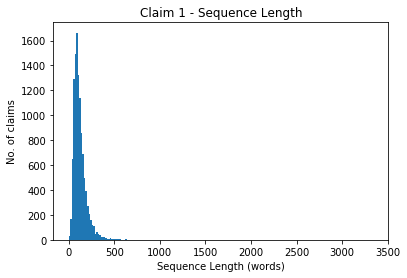

In [13]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

X_length = [len(x) for x in X_seqs]
max_length = max(X_length)
print("Our longest sequence is {0} tokens long.".format(max_length))

bins = np.linspace(0, max_length, 200)
plt.hist(X_length, bins)
plt.title('Claim 1 - Sequence Length')
plt.ylabel('No. of claims');
plt.xlabel('Sequence Length (words)');

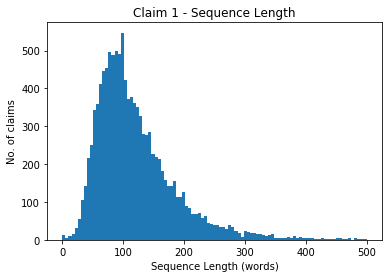

In [14]:
# Let's zoom in on 0 to 500
bins = np.linspace(0, 500, 100)
plt.hist(X_length, bins)
plt.title('Claim 1 - Sequence Length')
plt.ylabel('No. of claims');
plt.xlabel('Sequence Length (words)');

Let's limit our sequence length to 300 on our input.

Our longest sequence is 57 tokens long.


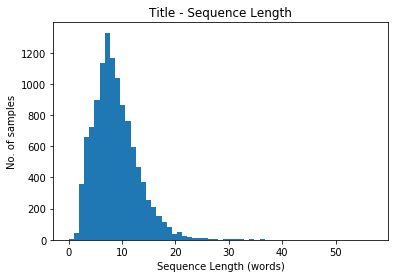

In [15]:
Y_length = [len(y) for y in Y_seqs]
max_y_length = max(Y_length)
print("Our longest sequence is {0} tokens long.".format(max_y_length))

bins = np.linspace(0, max_y_length, 60)
plt.hist(Y_length, bins)
plt.title('Title - Sequence Length')
plt.ylabel('No. of samples');
plt.xlabel('Sequence Length (words)');

Let's limit to 20 on our output.  

So we can pad our input and output sequences, limiting to 300 on the input and 20 on the output.

In [16]:
from keras.preprocessing.sequence import pad_sequences

X = pad_sequences(X_seqs, maxlen=300)
Y = pad_sequences(Y_seqs, maxlen=20)

In [17]:
print("Our X data has shape {0} and our Y data has shape {1}".format(X.shape, Y.shape))

Our X data has shape (11428, 300) and our Y data has shape (11428, 20)


## Building the Sequence to Sequence Model

In [18]:
# Some hyperparameters - start with those used in this example -
# https://github.com/fchollet/keras/blob/master/examples/lstm_seq2seq.py
batch_size = 64  # Batch size for training.
epochs = 20  # Number of epochs to train for.

# The number of encoder tokens - we have limited our vocabulary to 10000
X_vocab_len = 10000 
X_max_len = 300
# We limit our decoder to a vocabulary of 5000
y_vocab_len = 5000
y_max_len = 20

hidden_size = 100 # Latent dimensionality of the encoding space.
num_layers = 1

This blog post - https://chunml.github.io/ChunML.github.io/project/Sequence-To-Sequence/ and the code here - https://github.com/ChunML/seq2seq/blob/master/seq2seq_utils.py is useful for a word level seq2seq model.  

We can have the input as integers but we need the decoder output (i.e. our Y) as one-hot encoding. 

In [19]:
def to_one_hot(input_seqs, seq_max_len, vocab_len):
    """ Convert a sequence of integers to a sequence of one-hot vectors."""
    one_hot = np.zeros((len(input_seqs), seq_max_len, vocab_len))
    for i, sequence in enumerate(input_seqs):
        for t, word_int in enumerate(sequence):
            one_hot[i, t, word_int] = 1
    return one_hot

We get a memory error when we try to create a complete Y_one_hot matrix. As per the above blogpost we can chop into blocks of 1000 for training.

In [20]:
max([max(y) for y in Y])

4999

In [21]:
from keras.models import Sequential
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent, Embedding
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam, RMSprop

def create_model(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers):
    model = Sequential()

    # Creating encoder network
    model.add(Embedding(X_vocab_len, 1000, input_length=X_max_len, mask_zero=True))
    model.add(LSTM(hidden_size))
    model.add(RepeatVector(y_max_len))

    # Creating decoder network
    for _ in range(num_layers):
        model.add(LSTM(hidden_size, return_sequences=True))
    model.add(TimeDistributed(Dense(y_vocab_len)))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])
    return model

In [22]:
print('[INFO] Compiling model...')
model = create_model(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers)

[INFO] Compiling model...


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 1000)         10000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               440400    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 100)           80400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 5000)          505000    
_________________________________________________________________
activation_1 (Activation)    (None, 20, 5000)          0         
Total params: 11,025,800
Trainable params: 11,025,800
Non-trainable params: 0
________________________________________________________________

In [24]:
from keras.callbacks import ModelCheckpoint

k_start = 0


for k in range(k_start, epochs+1):
    # Shuffling the training data every epoch to avoid local minima
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]

    # Training 1000 sequences at a time
    for i in range(0, len(X), 1000):
        if i + 1000 >= len(X):
            i_end = len(X)
        else:
            i_end = i + 1000
        y_sequences = to_one_hot(Y[i:i_end], y_max_len, y_vocab_len)

        print('[INFO] Training model: epoch {}th {}/{} samples'.format(k, i, len(X)))
        
        
        model.fit(X[i:i_end], y_sequences, batch_size=batch_size, epochs=1, verbose=2)
    model.save_weights('checkpoint_epoch_{}.hdf5'.format(k))

[INFO] Training model: epoch 0th 0/11428 samples
Epoch 1/1


/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:405: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


287s - loss: 6.1390 - acc: 0.5384
[INFO] Training model: epoch 0th 1000/11428 samples
Epoch 1/1
270s - loss: 3.8113 - acc: 0.5733
[INFO] Training model: epoch 0th 2000/11428 samples
Epoch 1/1
287s - loss: 3.3611 - acc: 0.5739
[INFO] Training model: epoch 0th 3000/11428 samples
Epoch 1/1
332s - loss: 3.3687 - acc: 0.5711
[INFO] Training model: epoch 0th 4000/11428 samples
Epoch 1/1
324s - loss: 3.3579 - acc: 0.5738
[INFO] Training model: epoch 0th 5000/11428 samples
Epoch 1/1
313s - loss: 3.3085 - acc: 0.5797
[INFO] Training model: epoch 0th 6000/11428 samples
Epoch 1/1
257s - loss: 3.4082 - acc: 0.5678
[INFO] Training model: epoch 0th 7000/11428 samples
Epoch 1/1
241s - loss: 3.4375 - acc: 0.5634
[INFO] Training model: epoch 0th 8000/11428 samples
Epoch 1/1
241s - loss: 3.4586 - acc: 0.5649
[INFO] Training model: epoch 0th 9000/11428 samples
Epoch 1/1
241s - loss: 3.4049 - acc: 0.5746
[INFO] Training model: epoch 0th 10000/11428 samples
Epoch 1/1
241s - loss: 3.4159 - acc: 0.5709
[INFO

239s - loss: 3.1373 - acc: 0.5751
[INFO] Training model: epoch 7th 3000/11428 samples
Epoch 1/1
238s - loss: 3.1758 - acc: 0.5728
[INFO] Training model: epoch 7th 4000/11428 samples
Epoch 1/1
240s - loss: 3.1753 - acc: 0.5706
[INFO] Training model: epoch 7th 5000/11428 samples
Epoch 1/1
239s - loss: 3.2149 - acc: 0.5611
[INFO] Training model: epoch 7th 6000/11428 samples
Epoch 1/1
240s - loss: 3.2025 - acc: 0.5716
[INFO] Training model: epoch 7th 7000/11428 samples
Epoch 1/1
239s - loss: 3.1298 - acc: 0.5801
[INFO] Training model: epoch 7th 8000/11428 samples
Epoch 1/1
239s - loss: 3.1686 - acc: 0.5738
[INFO] Training model: epoch 7th 9000/11428 samples
Epoch 1/1
239s - loss: 3.1335 - acc: 0.5743
[INFO] Training model: epoch 7th 10000/11428 samples
Epoch 1/1
239s - loss: 3.1897 - acc: 0.5685
[INFO] Training model: epoch 7th 11000/11428 samples
Epoch 1/1
102s - loss: 3.3269 - acc: 0.5539
[INFO] Training model: epoch 8th 0/11428 samples
Epoch 1/1
240s - loss: 3.1597 - acc: 0.5705
[INFO] 

KeyboardInterrupt: 

Accuracy doesn't really raise above 57% - need to look at what is happening and revise code.

In [25]:
# Testing Code
X_test = load_test_data('test', X_word_to_ix, MAX_LEN)
X_test = pad_sequences(X_test, maxlen=X_max_len, dtype='int32')
model.load_weights(saved_weights)
            
predictions = np.argmax(model.predict(X_test), axis=2)
sequences = []
for prediction in predictions:
    sequence = ' '.join([y_ix_to_word(index) for index in prediction if index > 0])
    print(sequence)
    sequences.append(sequence)
np.savetxt('test_result', sequences, fmt='%s')

NameError: name 'load_test_data' is not defined

Word2Word model as above is very slow to train.  

Ideas to speed up:
- Have characters on the output.
- Use the model from the Keras blog post (see below).

(We also haven't got any test data! We'll need to grab some more claims.)
